<a href="https://colab.research.google.com/github/NaviaEddy/PerceiverIO_SIS421/blob/main/PerceiverIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PerceiverIO

## Clasificación de imágenes

Vamos a entrenar un clasificador de imágenes usando la arquitectura *PerceiverIO*. Para ello, usaremos el dataset CIFAR10.

In [16]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 823.3 kB/s eta 0:00:00


In [1]:
import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).float(), torch.tensor(self.labels[ix]).long()

In [3]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

ds['train'].imgs.shape, ds['test'].imgs.shape

100%|██████████| 170498071/170498071 [00:01<00:00, 92565494.07it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
batch_size = 64
num_workers = 0

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([64, 32, 32, 3]), torch.Size([64]))

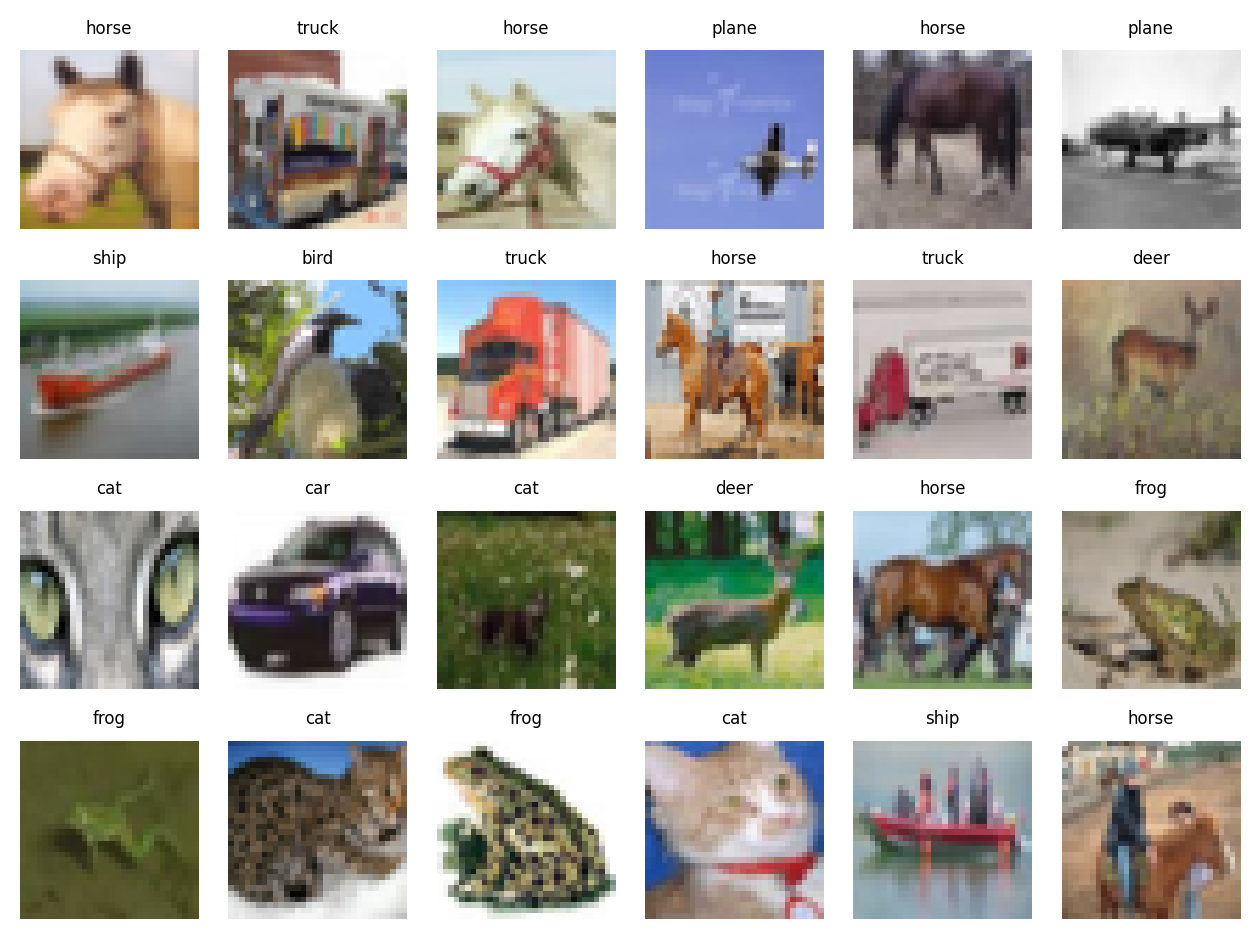

In [5]:
fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        ax.set_title(ds['train'].classes[labels[ix].item()], fontsize=6)
        ax.axis('off')
plt.tight_layout()
plt.show()

## *Atencion-Cruzada*

In [6]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.n_embd = q_dim
        self.n_heads = n_heads
        assert self.n_embd % self.n_heads == 0
        # key, query, value projections
        self.key = torch.nn.Linear(kv_dim, self.n_embd)
        self.query = torch.nn.Linear(q_dim, self.n_embd)
        self.value = torch.nn.Linear(kv_dim, self.n_embd)
        # regularization
        self.attn_drop = torch.nn.Dropout(attn_pdrop)
        self.resid_drop = torch.nn.Dropout(resid_pdrop)
        # output projection
        self.proj = torch.nn.Linear(self.n_embd, q_dim)

    def forward(self, kv, q, mask = None):
        B, M, C = kv.size()
        B, N, D = q.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        q = self.query(q).view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, N, hs)
        v = self.value(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        # attention (B, nh, N, hs) x (B, nh, hs, M) -> (B, nh, N, M)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if mask is not None:
            att = att.masked_fill(self.mask[:,:,:N,:M] == 0, float('-inf'))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, N, M) x (B, nh, M, hs) -> (B, nh, N, hs)
        y = y.transpose(1, 2).contiguous().view(B, N, D) # re-assemble all head outputs side by side
        return self.resid_drop(self.proj(y)) # B, N, D

In [7]:
class Block(torch.nn.Module):
    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.ln1_kv = torch.nn.LayerNorm(kv_dim)
        self.ln1_q = torch.nn.LayerNorm(q_dim)
        self.ln2 = torch.nn.LayerNorm(q_dim)
        self.attn = MultiHeadAttention(kv_dim, q_dim, n_heads, attn_pdrop, resid_pdrop)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(q_dim, 4 * q_dim),
            torch.nn.GELU(),
            torch.nn.Linear(4 * q_dim, q_dim),
            torch.nn.Dropout(resid_pdrop),
        )

    def forward(self, kv, q, mask=None):
        x = q + self.attn(self.ln1_kv(kv), self.ln1_q(q), mask)
        x = x + self.mlp(self.ln2(x))
        return x

## Perceiver

In [8]:
class Perceiver(torch.nn.Module):
    def __init__(self, num_latents, latent_dim, input_dim, num_blocks, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.num_blocks = num_blocks
        self.latents = torch.nn.Parameter(torch.randn(num_latents, latent_dim))
        # encode
        self.cross_attn = Block(
            kv_dim=input_dim,
            q_dim=latent_dim,
            n_heads=n_heads,
            attn_pdrop=attn_pdrop,
            resid_pdrop=resid_pdrop
        )
        # process
        self.self_attention_blocks = torch.nn.ModuleList([
            Block(
                kv_dim=latent_dim,
                q_dim=latent_dim,
                n_heads=n_heads,
                attn_pdrop=attn_pdrop,
                resid_pdrop=resid_pdrop
            ) for _ in range(num_blocks)
        ])

    def forward(self, x, mask = None):
        B = x.size(0)
        if mask is not None:
            mask = mask[None, None, :, :]
        x = self.cross_attn(
            kv=x,
            q=self.latents.repeat(B, 1, 1),
            mask=mask
        )
        for _ in range(self.num_blocks):
            for self_attn_layer in self.self_attention_blocks:
                x = self_attn_layer(x, x)
        return x


Los Transformers son equivariantes al orden de las entradas. Esto significa que no prestan atención al orden en el que la damos los inputs, lo cual puede ser importante para la tarea en cuestión. En el caso de los Transformers, la solución más común es el uso de positional encoding, que consiste en proporcionar informacion sobre la posicion de cada pixel o patch de la imagen concatenandolo a los embedings preservando la estructura de la imagen. En el caso del Perceiver, los autores proponen el uso de Fourier features, que consiste en concatenar la dimensión de los canales para cada pixel de la imagen en una serie de valores que codifican su posición relativa para que el modelo pueda usar esta información.

In [9]:
from math import pi, log

def fourier_encode(x, max_freq, num_bands = 4, base = 2):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x
    scales = torch.logspace(0., log(max_freq / 2) / log(base), num_bands, base = base, device = device, dtype = dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), ...)]
    x = x * scales * pi
    x = torch.cat([x.sin(), x.cos()], dim=-1)
    x = torch.cat((x, orig_x), dim = -1)
    return x

In [17]:
from einops import rearrange, repeat

class Model(torch.nn.Module):
    def __init__(self, num_classes, max_freq, num_freq_bands, num_latents, latent_dim, input_dim, num_blocks, freq_base = 2, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.num_freq_bands = num_freq_bands
        self.freq_base = freq_base
        self.max_freq = max_freq
        fourier_channels = (2 * ((num_freq_bands * 2) + 1))
        input_dim += fourier_channels
        self.perceiver = Perceiver(num_latents, latent_dim, input_dim, num_blocks, n_heads, attn_pdrop, resid_pdrop)
        self.fc = torch.nn.Linear(latent_dim, num_classes)

    def forward(self, x, mask = None):
        # fourier encoding
        b, *axis, _, device = *x.shape, x.device
        axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps = size, device = device), axis))
        pos = torch.stack(torch.meshgrid(*axis_pos), dim = -1)
        enc_pos = fourier_encode(pos, self.max_freq, self.num_freq_bands, base = self.freq_base)
        enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
        enc_pos = repeat(enc_pos, '... -> b ...', b = b)
        x = torch.cat((x, enc_pos), dim = -1)
        x = rearrange(x, 'b ... d -> b (...) d')
        # fourier encoding -> apply perceiver -> process
        x = self.perceiver(x, mask)
        # process -> final classification decoding
        return self.fc(x.mean(1))

# **Entrenamiento del modelo**

In [18]:
from tqdm import tqdm
import torch.nn.functional as F

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda", overfit=False):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        # como cambiar el shuffle a False si overfit ?
        for batch in bar:
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            if overfit:
                break
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        if overfit:
            bar = tqdm(dl['train'])
        else:
            bar = tqdm(dl['test'])
        with torch.inference_mode():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
                if overfit:
                    break
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
    return hist

In [19]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

In [20]:
model = Model(num_classes=10, max_freq=5, num_freq_bands=3, num_latents=32, latent_dim=32, input_dim=3, num_blocks=3)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=64, shuffle=False, num_workers=0)
}

In [21]:
hist = train(model, dl, optimizer, epochs=30, overfit=False)

testing... loss 1.9757 acc 0.2551: 100%|██████████| 157/157 [00:01<00:00, 93.27it/s]


Epoch 1/30 loss 2.1013 acc 0.1967 test_loss 1.9757 test_acc 0.2551


testing... loss 1.8696 acc 0.3152: 100%|██████████| 157/157 [00:01<00:00, 93.36it/s]


Epoch 2/30 loss 1.9482 acc 0.2771 test_loss 1.8696 test_acc 0.3152


testing... loss 1.8138 acc 0.3311: 100%|██████████| 157/157 [00:01<00:00, 91.99it/s]


Epoch 3/30 loss 1.8645 acc 0.3170 test_loss 1.8138 test_acc 0.3311


testing... loss 1.7380 acc 0.3652: 100%|██████████| 157/157 [00:01<00:00, 92.69it/s]


Epoch 4/30 loss 1.7978 acc 0.3436 test_loss 1.7380 test_acc 0.3652


testing... loss 1.7403 acc 0.3649: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


Epoch 5/30 loss 1.7351 acc 0.3660 test_loss 1.7403 test_acc 0.3649


testing... loss 1.6442 acc 0.4000: 100%|██████████| 157/157 [00:02<00:00, 73.18it/s]


Epoch 6/30 loss 1.6745 acc 0.3881 test_loss 1.6442 test_acc 0.4000


testing... loss 1.5880 acc 0.4234: 100%|██████████| 157/157 [00:01<00:00, 86.78it/s]


Epoch 7/30 loss 1.6100 acc 0.4133 test_loss 1.5880 test_acc 0.4234


testing... loss 1.5107 acc 0.4565: 100%|██████████| 157/157 [00:01<00:00, 92.63it/s]


Epoch 8/30 loss 1.5595 acc 0.4358 test_loss 1.5107 test_acc 0.4565


testing... loss 1.4898 acc 0.4615: 100%|██████████| 157/157 [00:01<00:00, 91.84it/s]


Epoch 9/30 loss 1.5172 acc 0.4501 test_loss 1.4898 test_acc 0.4615


testing... loss 1.4702 acc 0.4659: 100%|██████████| 157/157 [00:01<00:00, 86.61it/s]


Epoch 10/30 loss 1.4786 acc 0.4613 test_loss 1.4702 test_acc 0.4659


testing... loss 1.4495 acc 0.4742: 100%|██████████| 157/157 [00:01<00:00, 93.73it/s]


Epoch 11/30 loss 1.4461 acc 0.4749 test_loss 1.4495 test_acc 0.4742


testing... loss 1.4474 acc 0.4799: 100%|██████████| 157/157 [00:01<00:00, 90.43it/s]


Epoch 12/30 loss 1.4220 acc 0.4855 test_loss 1.4474 test_acc 0.4799


testing... loss 1.4044 acc 0.4912: 100%|██████████| 157/157 [00:02<00:00, 70.81it/s]


Epoch 13/30 loss 1.3972 acc 0.4930 test_loss 1.4044 test_acc 0.4912


testing... loss 1.4160 acc 0.4863: 100%|██████████| 157/157 [00:01<00:00, 93.00it/s]


Epoch 14/30 loss 1.3751 acc 0.5025 test_loss 1.4160 test_acc 0.4863


testing... loss 1.3816 acc 0.4988: 100%|██████████| 157/157 [00:01<00:00, 91.87it/s]


Epoch 15/30 loss 1.3540 acc 0.5111 test_loss 1.3816 test_acc 0.4988


testing... loss 1.3879 acc 0.4985: 100%|██████████| 157/157 [00:01<00:00, 92.81it/s]


Epoch 16/30 loss 1.3366 acc 0.5176 test_loss 1.3879 test_acc 0.4985


testing... loss 1.3420 acc 0.5222: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


Epoch 17/30 loss 1.3211 acc 0.5219 test_loss 1.3420 test_acc 0.5222


testing... loss 1.3415 acc 0.5157: 100%|██████████| 157/157 [00:01<00:00, 92.03it/s]


Epoch 18/30 loss 1.3056 acc 0.5294 test_loss 1.3415 test_acc 0.5157


testing... loss 1.3307 acc 0.5203: 100%|██████████| 157/157 [00:01<00:00, 89.80it/s]


Epoch 19/30 loss 1.2905 acc 0.5359 test_loss 1.3307 test_acc 0.5203


testing... loss 1.3168 acc 0.5224: 100%|██████████| 157/157 [00:02<00:00, 69.08it/s]


Epoch 20/30 loss 1.2785 acc 0.5400 test_loss 1.3168 test_acc 0.5224


testing... loss 1.3174 acc 0.5297: 100%|██████████| 157/157 [00:02<00:00, 75.22it/s]


Epoch 21/30 loss 1.2653 acc 0.5453 test_loss 1.3174 test_acc 0.5297


testing... loss 1.3086 acc 0.5306: 100%|██████████| 157/157 [00:01<00:00, 92.06it/s]


Epoch 22/30 loss 1.2484 acc 0.5511 test_loss 1.3086 test_acc 0.5306


testing... loss 1.3090 acc 0.5309: 100%|██████████| 157/157 [00:01<00:00, 92.93it/s]


Epoch 23/30 loss 1.2356 acc 0.5564 test_loss 1.3090 test_acc 0.5309


testing... loss 1.2863 acc 0.5309: 100%|██████████| 157/157 [00:01<00:00, 92.73it/s]


Epoch 24/30 loss 1.2240 acc 0.5612 test_loss 1.2863 test_acc 0.5309


testing... loss 1.2806 acc 0.5342: 100%|██████████| 157/157 [00:01<00:00, 91.51it/s]


Epoch 25/30 loss 1.2101 acc 0.5648 test_loss 1.2806 test_acc 0.5342


testing... loss 1.2894 acc 0.5394: 100%|██████████| 157/157 [00:01<00:00, 92.13it/s]


Epoch 26/30 loss 1.1995 acc 0.5686 test_loss 1.2894 test_acc 0.5394


testing... loss 1.2821 acc 0.5424: 100%|██████████| 157/157 [00:01<00:00, 83.75it/s]


Epoch 27/30 loss 1.1867 acc 0.5738 test_loss 1.2821 test_acc 0.5424


testing... loss 1.2509 acc 0.5535: 100%|██████████| 157/157 [00:02<00:00, 71.23it/s]


Epoch 28/30 loss 1.1776 acc 0.5771 test_loss 1.2509 test_acc 0.5535


testing... loss 1.2493 acc 0.5513: 100%|██████████| 157/157 [00:01<00:00, 83.91it/s]


Epoch 29/30 loss 1.1670 acc 0.5805 test_loss 1.2493 test_acc 0.5513


testing... loss 1.2828 acc 0.5437: 100%|██████████| 157/157 [00:01<00:00, 93.51it/s]

Epoch 30/30 loss 1.1539 acc 0.5864 test_loss 1.2828 test_acc 0.5437


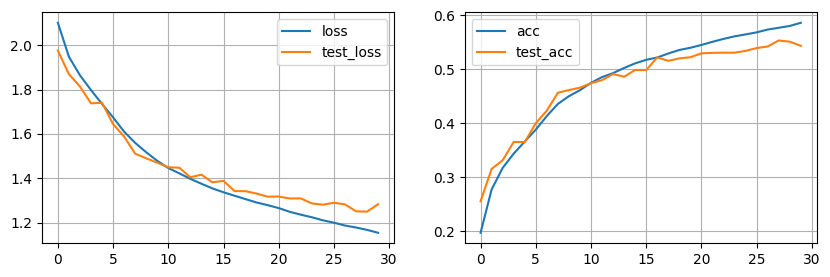

In [22]:
plot_hist(hist)

Tras 30 epochs nuestro modelo está convergiendo ! Los resultados no son nada del otro mundo, sin embargo es un buen punto de partida para empezar a experimentar con esta nueva arquitectura de red neuronal.

In [23]:
imgs, labels = next(iter(dl['train']))

model.eval()
with torch.inference_mode():
    logits = model(imgs.cuda())
    preds = torch.argmax(logits, axis=1).cpu()

preds.shape

torch.Size([64])

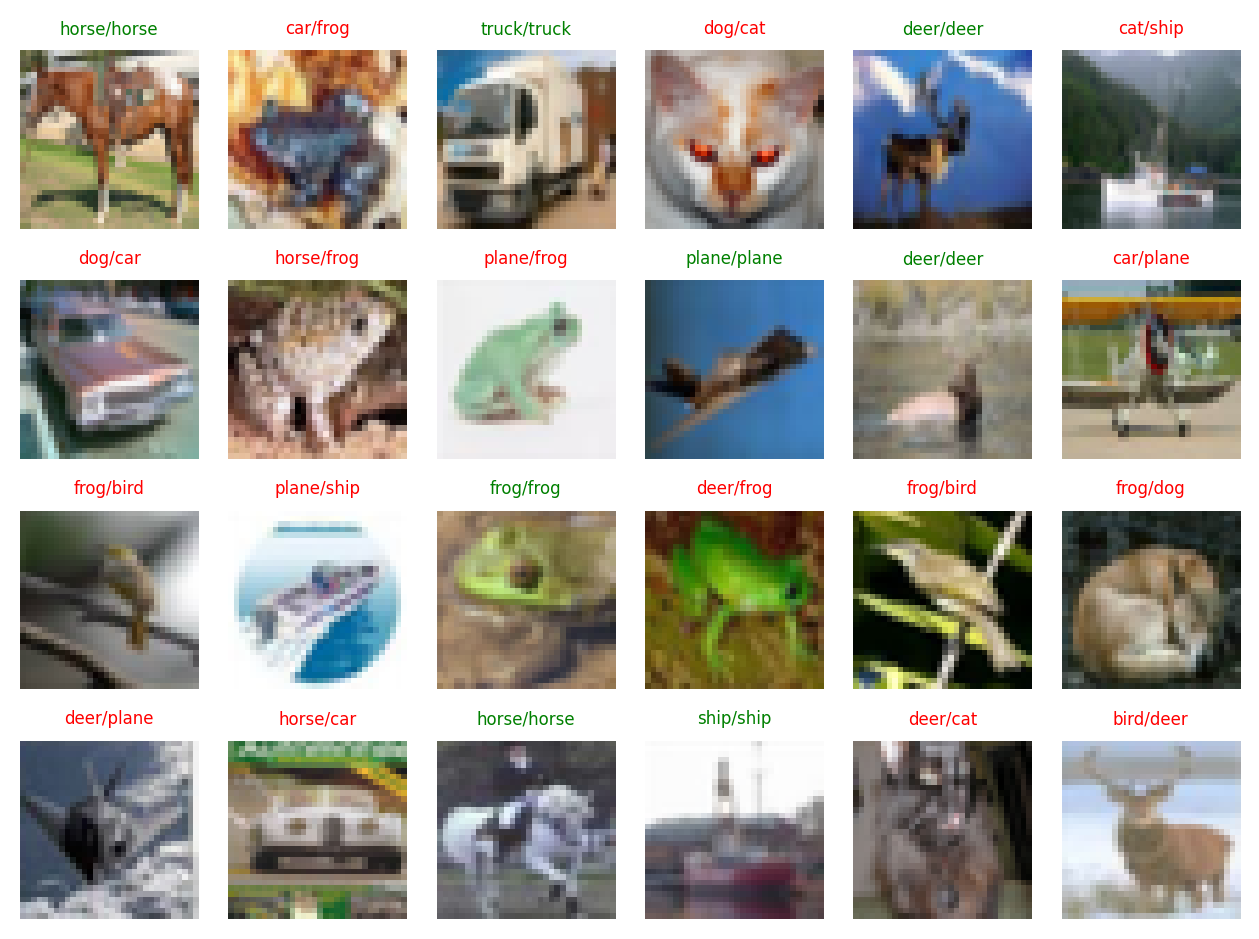

In [24]:
fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        gt = ds['test'].classes[labels[ix].item()]
        pr = ds['test'].classes[preds[ix].item()]
        ax.set_title(f'{pr}/{gt}', fontsize=6, color='green' if pr == gt else 'red')
        ax.axis('off')
plt.tight_layout()
plt.show()

En el siguiente post extenderemos nuestra arquitectura para adaptarla al modelo de *PerceiverIO*, a partir de lo cual empezaremos a experimentar con diferentes tareas y modalidades de datos para demostrar la potencialidad de esta red neuronal.

## Resumen

En este post hemos introducido la arquitectura de red neuronal *Perceiver*, base del modelo más avanzado *Perceiver IO* que veremos en los siguientes posts. Este modelo se basa en *Transformers* para la extracción de características de nuestros datos. Gracias al uso de una primera capa de *cross-attention* con un vector de *query* aprendido y con dimensiones fijas, podemos proyectar nuestros *inputs* a la dimensión deseada. Esto nos da dos ventajas: en primer lugar, podemos usar inputs mucho más grandes que con *Transformers* tradicionales. Por otro lado, podemos usar inputs multi-modales. En este post hemos visto un ejemplo para clasificación de imagen con el dataset CIFAR10. A diferencia de otras arquitecturas de *transformers*, como *ViT*, *Perceiver* es capaz de atender a todos los pixels de la imagen sin necesitar extraer y proyectar *patches*.

## Recursos

- [Paper](https://arxiv.org/pdf/2103.03206.pdf)
- [Blog](https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data) DeepMind.
- Videos:
    1. [Yannic Kilcher](https://www.youtube.com/watch?v=P_xeshTnPZg)
    2. [The AI Epiphany](https://www.youtube.com/watch?v=WJWBq4NZfvY&feature=youtu.be)
- Código:
    1. Implementación original de [DeepMind](https://github.com/deepmind/deepmind-research/tree/master/perceiver) (JAX)
    2. Pytorch: [lucidrains](https://github.com/lucidrains/perceiver-pytorch), [esceptico](https://github.com/esceptico/perceiver-io)